# Introducción
tal

Cargamos las librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import log
from mpl_toolkits.mplot3d import Axes3D

# Modelo clásico $(K_v \to\infty)$
Vamos a implementar Lotka-Volterra para $N=4$ especies. Usaremos la expresión
$$
\frac{dx_i}{dt} = r_ix_i\left( 1- \sum_{j=1}^N a_{ij}x_j \right)
$$



In [2]:
# generamos las funciones para cada especie

def system(t,x,r,a):
    '''
    :param x: vector de longitud N
    :param r: vector de tasa de crecimiento (r_i)
    :param a: matriz (N,N) con los coeficientes a_ij
    :return: numpy array
    '''
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
        interaction = np.sum(a[i,:]*x)
        dxdt[i] = r[i] * x[i] * (1 - interaction)
    return dxdt

## Representación del sistema

In [38]:
# resolvemos con integración

N=4
r = np.array(
    [1, 0.72, 1.53, 1.27]
)

a = np.array([
    [1, 1.09, 1.52, 0],
    [0, 1, 0.44, 1.36],
    [2.33, 0, 1, 0.47],
    [1.21, 0.51, 0.35, 1]
])

x0 = np.array([0.5, 0.5, 0.5, 0.5])
t_span = (0, 500) # con 1e3 queda chulo
t_eval =np.linspace(t_span[0],t_span[1], 10000) 
sol = solve_ivp(system, t_span, x0, args=(r,a), t_eval = t_eval)
print(len(sol.y[0]))

10000


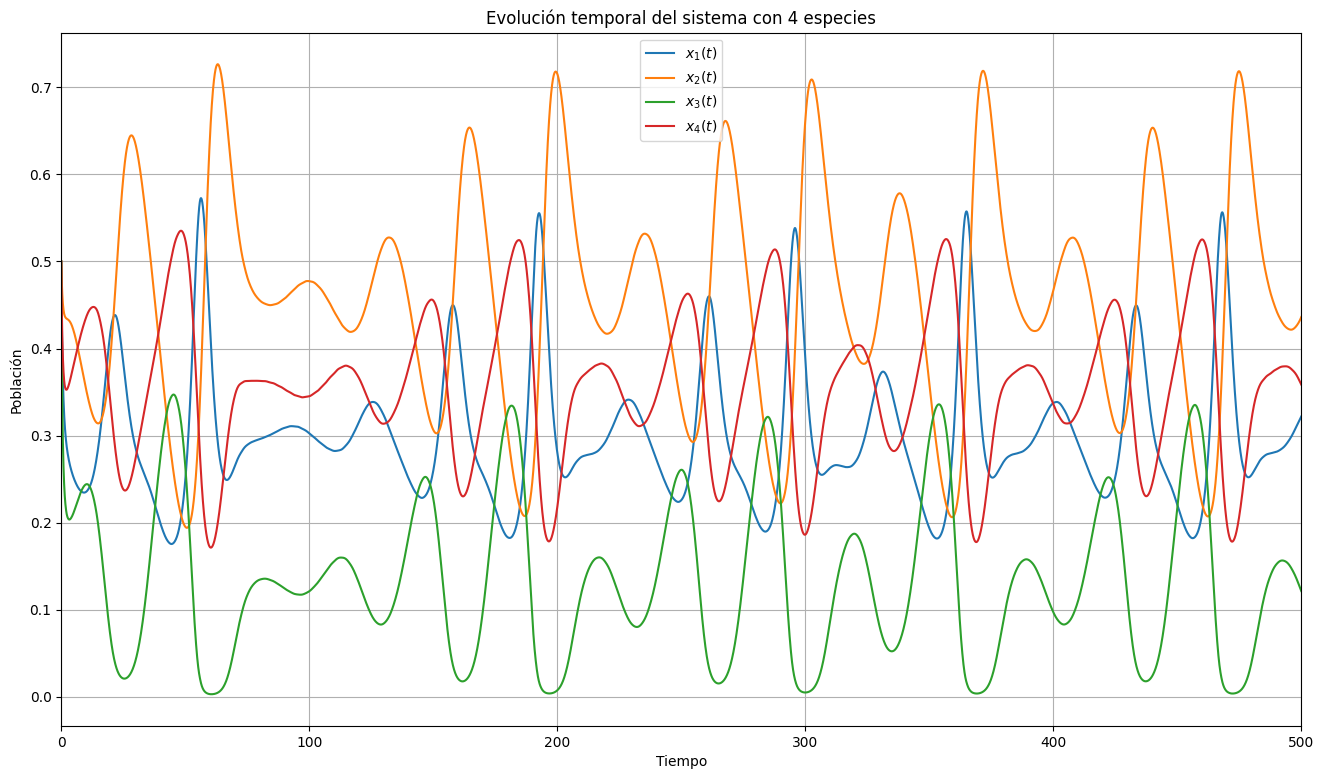

In [39]:
# %matplotlib notebook

# creamos la gráfica
fig, ax = plt.subplots(1, 1, figsize=(16,9))

ax.plot(sol.t, sol.y[0], label=f'$x_1(t)$')
ax.plot(sol.t, sol.y[1], label=f'$x_2(t)$')
ax.plot(sol.t, sol.y[2], label=f'$x_3(t)$')
ax.plot(sol.t, sol.y[3], label=f'$x_4(t)$')

# ajustamos las etiquetas y el título
ax.set_xlabel('Tiempo')
ax.set_ylabel('Población')
ax.set_xlim([0, t_span[-1]])
ax.set_title('Evolución temporal del sistema con 4 especies')
ax.legend()
ax.grid(True)
plt.plot()

# mostramos la gráfica
plt.show()

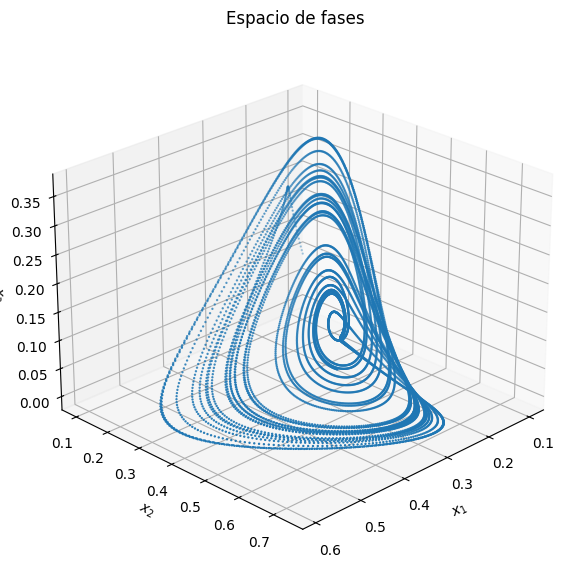

In [5]:
# creamos figura y ejes 3d
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# dibujamos el espacio de fases
ax.scatter(sol.y[0],sol.y[1],sol.y[2] , label='Espacio de fases', s=0.5)
ax.set_xlabel(f'$x_1$')
ax.set_ylabel(f'$x_2$')
ax.set_zlabel(f'$x_3$')
ax.set_title('Espacio de fases')

ax.view_init(elev=25, azim=45)  # cambia elevación y azimut para rotar la gráfica
plt.show()

## Cálculo de los exponentes de Lyapunov
Para este sistema tenemos el siguiente Jacobiano:
$$
J_{ik}=\frac{\partial \dot x_i}{\partial x_k} = r_i\left[\left( 1-\sum_{j=1}^Na_{ij}x_j \right)\delta_{ik} -x_ia_{ik} \right].
$$

In [6]:
def compute_LCEs(x0, r, a, t_span, n_subdiv=100, method='RK45', max_step=None):
    """
    Calcula los exponentes de Lyapunov de un sistema continuo mediante el método QR.

    Parámetros
    ----------
    x0 : array de dimensión N
         Condición inicial del estado del sistema.
    r : array de dimensión N
        Parámetros r_i del sistema.
    a : array de dimensión N x N
        Matriz de interacciones a_{ij}.
    t_span : tuple (t0, tf)
        Intervalo de integración.
    n_subdiv : int, opcional (por defecto 100)
        Número de subdivisiones para la re-ortonormalización.
        Por ejemplo, si t_span=(0,1000) y n_subdiv=100, se aplica QR cada 10 unidades de tiempo.
    method : str, opcional (por defecto 'RK45')
        Método de integración de solve_ivp.
    max_step : float, opcional
        Paso máximo de integración para solver_ivp. Si None, no se limita el paso.

    Output
    -------
    LCEs : array de dimensión N
        Estimación final de los exponentes de Lyapunov.
    times : array
        Tiempos en que se realizó cada re-ortonormalización.
    LCE_convergence : array de dimensión (#reort x N)
        Evolución de la estimación de LCEs a lo largo del tiempo.
    """
    
    N = len(r)
    t0, tf = t_span
    
    # Matriz Phi inicial (identidad)
    Phi0 = np.eye(N)
    
    # Estado extendido inicial: [x0, Phi0 vectorizado]
    X0 = np.concatenate([x0, Phi0.flatten()])
    
    # Tiempo entre re-ortonormalizaciones
    dt = (tf - t0) / n_subdiv
    
    # Puntos en los que aplicaremos re-ortonormalización:
    times_eval = np.linspace(t0, tf, n_subdiv+1)
    
    # Inicializamos el acumulador de sumas logarítmicas
    log_factors = np.zeros(N)
    LCE_convergence = []
    times = []

    current_state = X0
    current_t = t0

    def extended_system(t, X):
        # Función interna para solve_ivp
        return _extended_system(t, X, r, a)

    for i in range(n_subdiv):
        # Integrar desde current_t hasta current_t+dt
        t_next = times_eval[i+1]
        
        sol = solve_ivp(extended_system,
                        (current_t, t_next),
                        current_state,
                        method=method,
                        vectorized=False,
                        dense_output=False,
                        max_step=max_step)  # Aquí aplicamos el control del paso
        
        # Extraemos el estado final
        X_final = sol.y[:, -1]
        x_final = X_final[:N]
        Phi_final = X_final[N:].reshape(N, N)
        
        # Aplicamos descomposición QR a Phi_final
        Q, R = np.linalg.qr(Phi_final)
        
        # Actualizamos los logaritmos de los factores de expansión
        diag_R = np.diag(R)
        # sumamos el log de los valores absolutos de la diagonal de R
        log_factors += np.log(np.abs(diag_R))
        
        # Cálculo temporal de los LCE
        elapsed_time = (t_next - t0)
        LCE_estimate = log_factors / elapsed_time
        LCE_convergence.append(LCE_estimate)
        times.append(t_next)
        
        # Reestablecemos Phi_final normalizado
        Phi_normalized = Q
        # Actualizamos el estado extendido para el siguiente tramo
        current_state = np.concatenate([x_final, Phi_normalized.flatten()])
        current_t = t_next

    LCE_convergence = np.array(LCE_convergence)
    times = np.array(times)
    LCEs = LCE_convergence[-1]  # LCE finales
    return LCEs, times, LCE_convergence


def _extended_system(t, X, r, a):
    """
    Función auxiliar para ser llamada dentro de compute_LCEs.
    Calcula dx/dt y dPhi/dt para el sistema extendido.
    """
    N = len(r)
    
    x = X[:N]
    Phi = X[N:].reshape(N, N)
    
    # dx/dt
    Ax = a.dot(x)
    dx = r * x * (1 - Ax)  # vectorizado
    
    # Jacobiano
    J = _jacobiano(x, r, a)
    
    # dPhi/dt = J(x)*Phi
    dPhi = J.dot(Phi)
    dPhi_flat = dPhi.flatten()
    
    return np.concatenate([dx, dPhi_flat])


def _jacobiano(x, r, a):
    """
    Calcula el jacobiano J(x).
    """
    N = len(r)
    J = np.zeros((N, N))
    Ax = a.dot(x)
    for i in range(N):
        sum_aijxj = Ax[i]
        for k in range(N):
            if i == k:
                J[i, k] = r[i] * ((1 - sum_aijxj) - x[i]*a[i, i])
            else:
                J[i, k] = -r[i]*x[i]*a[i, k]
    return J

Calculamos finalmente los LCEs:

In [7]:

LCEs = compute_LCEs(x0, r, a, t_span, n_subdiv=1000, max_step=0.1)
print(LCEs[0], (LCEs[2][:,1]).shape)

[ 2.20774795e-02  6.53278608e-04 -2.74800879e-01 -1.02565396e+00] (1000,)


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\kikek\AppData\Local\Temp\ipykernel_93092\1442642375.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(LCEs[1], LCEs[2][:,0], label=f'$\lambda_1$')
C:\Users\kikek\AppData\Local\Temp\ipykernel_93092\1442642375.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(LCEs[1], LCEs[2][:,1], label=f'$\lambda_2$')
C:\Users\kikek\AppData\Local\Temp\ipykernel_93092\1442642375.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(LCEs[1], LCEs[2][:,2], label=f'$\lambda_3$')
C:\Users\kikek\AppData\Local\Temp\ipykernel_93092\1442642375.py:6: SyntaxWarning: invalid escape se

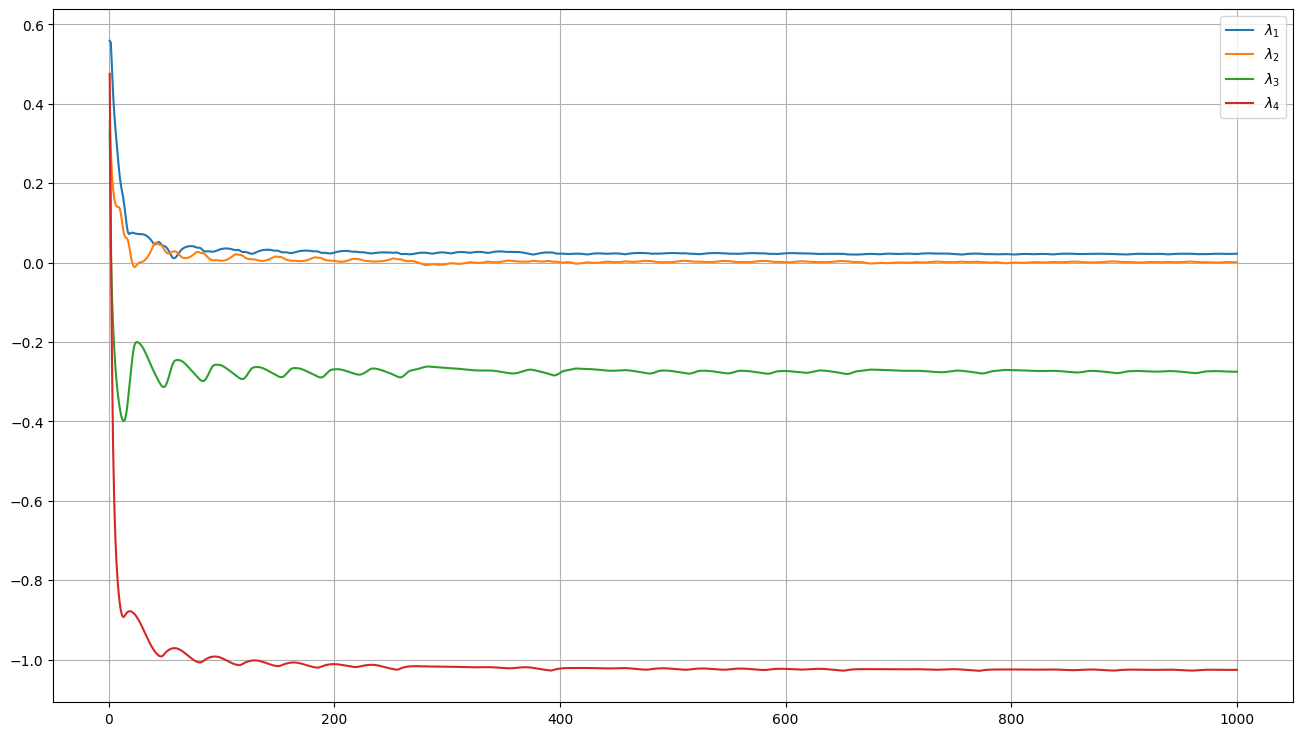

In [11]:
plt.figure(figsize=(16, 9))

plt.plot(LCEs[1], LCEs[2][:,0], label=f'$\lambda_1$')
plt.plot(LCEs[1], LCEs[2][:,1], label=f'$\lambda_2$')
plt.plot(LCEs[1], LCEs[2][:,2], label=f'$\lambda_3$')
plt.plot(LCEs[1], LCEs[2][:,3], label=f'$\lambda_4$')
plt.legend()
plt.grid()
plt.show()

# Modelo con regulación de densidad
Si ahora suponemos que $K_v$ es finito, tenemos las siguientes ecuaciones diferenciales acopladas:
$$
\begin{align} 
\frac{dV(\vec{x}, t)}{dt} &= r_v V(\vec{x}, t) \left[ 1 - \frac{V(\vec{x}, t)}{K_v} -\lambda_{vp}\frac{P(\vec{x}, t)}{K_v} \right] , \\
\frac{dP(\vec{x}, t)}{dt} &= -|r_p| P(\vec{x}, t)   \left[ 1 -\lambda_{pv}\frac{V(\vec{x}, t)}{K_v} \right] .
\end{align}
$$
Ahora tenemos dos ecuaciones diferenciales acopladas. Las definimos

In [5]:
def sistema(t, V, P, rv, rp, lambda_pv, lambda_vp, Kv):
    x = V
    y = P
    dx_dt = x*(rv*(1-x/Kv-lambda_vp*y/Kv))
    dy_dt = y*(-abs(rp)*(1-lambda_pv*x/Kv))
    return np.array([dx_dt, dy_dt])

También tenemos que hallar el Jacobiano del sistema, que es simplemente las derivadas de primer orden:
$$
J = 
\begin{pmatrix}
r_v\left( 1- \frac{2V}{K_v}-\lambda_{vp}\frac{P}{K_v}\right) & -\lambda_{vp}\frac{r_v V}{K_v} \\
|r_p|\lambda_{pv}\frac{P}{K_v} & -|r_p|\left( 1-\lambda_{pv}\frac{V}{K_v} \right)
\end{pmatrix}
$$

In [6]:
def jacobiano(V, P, rv, rp, lambda_pv, lambda_vp, Kv):
    J = np.array([
        [rv*(1-2*V/Kv-lambda_vp*P/Kv), -lambda_vp*rv*V/Kv],
        [abs(rp)*lambda_pv*P/Kv, -abs(rp)*(1-lambda_pv*V/Kv)]
    ])
    return J


## Sistema extendido
Ahora podemos definir las ecuaciones de variación lineal, definidas como
$$
\dot \vec \Phi = D_xF(x)\cdot \vec\Phi,
$$
donde $J(t)$ es nuestro Jacobiano en función del tiempo, y $\delta x$ es la matriz que contiene las perturbaciones que le vamos a aplicar al sistema. Claramente, $x$ es cualquiera de las dos variables de nuestro sistema $V,\ P$.

Creamos un sistema extendido que incluya estas perturbaciones, de forma que tendremos 
$$
\begin{bmatrix}
\dot x \\
\dot \vec \Phi
\end{bmatrix}

 =
 
\begin{bmatrix}
F( x) \\
D_x F(x)\cdot \vec\Phi
\end{bmatrix}

$$

Además, por la regla de la cadena tenemos
$$
D_x f^t(x_0) = J[f^{t-1}(x_0)] ... J[f(x_0)] J(x_0)
$$

In [7]:
def sistema_extendido(t, Z, rv, rp, lambda_pv, lambda_vp, Kv):
    # Z es nuestra matriz con el sistema y las perturbaciones
    # extraemos nuestro sistema inicial
    V, P = Z[:2]
    
    # evolución del sistema original
    dV_dt, dP_dt = sistema(t, V, P, rv, rp, lambda_pv, lambda_vp, Kv)
    
    # hallamos el jacobiano
    J = jacobiano(V, P, rv, rp, lambda_pv, lambda_vp, Kv)
    
    # extraemos las variaciones
    delta = Z[2:].reshape((2,2))   # nos da una matriz 2x2
    
    # ecuaciones de variación lineal
    d_delta_dt = J @ delta # producto matricial
    
    # unimos las derivadas originales y de las variaciones
    dZ_dt = np.concatenate(([dV_dt, dP_dt], d_delta_dt.flatten()))
    
    return dZ_dt

## Resolución en tiempo discreto

Ahora resolvemos el sistema extendido. Definimos condiciones iniciales en las variables originales, y en las perturbaciones. Usaremos 
$$
\begin{bmatrix}
\dot x(t_0) \\
\dot \vec \Phi(t_0)
\end{bmatrix}

 =
 
\begin{bmatrix}
x_0 \\
\mathbb{I}
\end{bmatrix}

$$

In [102]:
# condiciones iniciales y parámetros
V0 = .1  
P0 = .01  
rv = 1
rp = 0.1 
lambda_pv = 0.044 
lambda_vp = 0.044 
Kv = 1

delta0 = np.eye(2).flatten() # usamos matriz identidad aplanada (base canónica)

# vector de condidiones iniciales extendidas
Z0 = np.concatenate(([V0, P0], delta0))

# definimos un intervalo de tiempo
t_span = (0,1000)
t_eval = np.linspace(t_span[0],t_span[1], 10000)

# resolvemos el sistema extendido
sol = solve_ivp(sistema_extendido, t_span, Z0, t_eval = t_eval, args = (rv, rp, lambda_pv, lambda_vp, Kv))

# extraemos las soluciones
V_sol = sol.y[0]
P_sol = sol.y[1]
delta_sol = sol.y[2:].reshape((2, 2, -1))

Con esto podemos hacer varias gráficas para ver cómo se comporta el sistema de forma más visual:

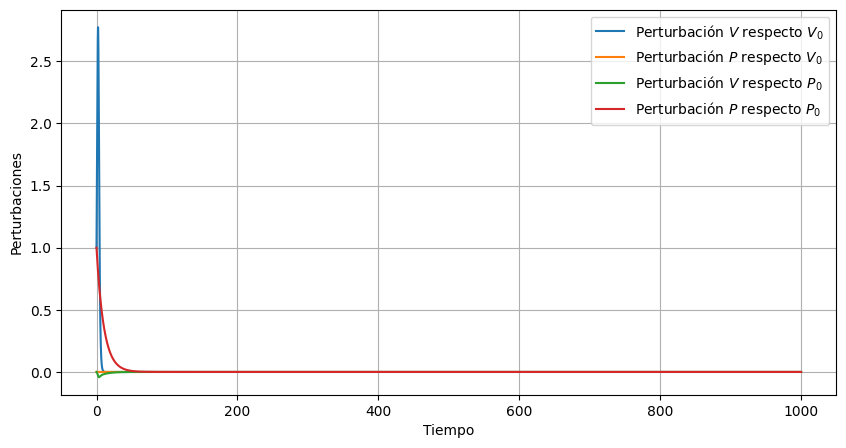

In [103]:
# 1. Evolución temporal de las perturbaciones
plt.figure(figsize=(10, 5))
plt.plot(sol.t, delta_sol[0, 0], label="Perturbación $V$ respecto $V_0$")
plt.plot(sol.t, delta_sol[1, 0], label="Perturbación $P$ respecto $V_0$")
plt.plot(sol.t, delta_sol[0, 1], label="Perturbación $V$ respecto $P_0$")
plt.plot(sol.t, delta_sol[1, 1], label="Perturbación $P$ respecto $P_0$")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Perturbaciones")
plt.grid()
plt.show()

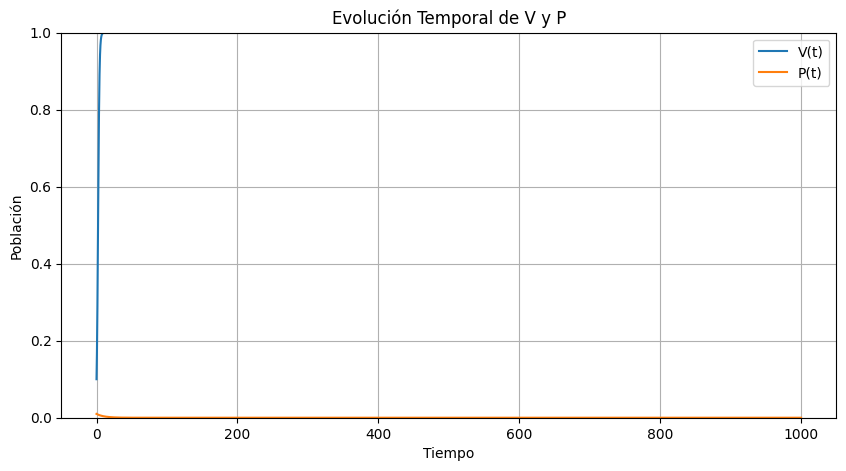

In [104]:
# 2. Evolución temporal de V(t) y P(t)
plt.figure(figsize=(10, 5))
plt.plot(sol.t, V_sol, label='V(t)')
plt.plot(sol.t, P_sol, label='P(t)')
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.title('Evolución Temporal de V y P')
plt.ylim([0,1])
plt.legend()
plt.grid()
plt.show()

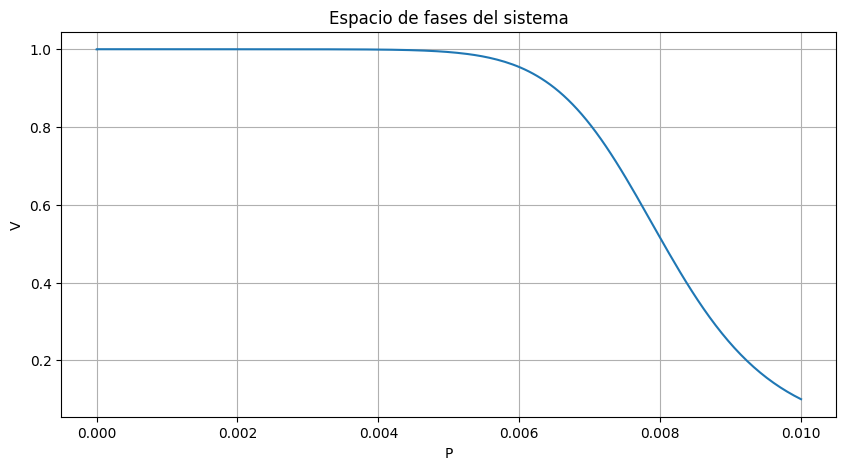

In [105]:
# 3. Espacio de fases
plt.figure(figsize=(10, 5))
plt.plot(P_sol, V_sol)
plt.xlabel('P')
plt.ylabel('V')
plt.title('Espacio de fases del sistema')
plt.grid()
plt.show()

## Cálculo de los exponentes de Lyapunov

Con el sistema extendido resulto, podemos calcular los exponentes característicos de Lyapunov (LCEs). Esto es, básicamente, hallar el crecimiento exponencial promedio de las perturbaciones a lo largo del tiempo. El LCE de orden $p$ se calcula como 
$$
\lambda_p = \lim_{k\to\infty} \frac{1}{kT}\sum_{i=1}^k \ln\| w_p^i \|.
$$

Para cada iteración, tenemos que hallar el Jacobiano $$J_k^* = J[f^{k-1}(x_0)]Q_{k-1},\quad k=2,3, ..., t, $$
donde $k$ es la iteración y $Q$ es la matriz ortogonal asociada al Jacobiano, $J_k = Q_k R_k$.
De esta forma, tenemos $$D_x f^t(x_0) = Q_t R_t ... R_1.$$

Finalmente, podemos hallar los LCEs con los valores diagonales $(\nu_{ii}^t)$ de $R_t$: 
$$\lambda_i = \lim_{t\to\infty} \frac1t \ln |\nu_{ii}^t|,$$
donde $(\nu_{ii}^t)$ son los elementos diagonales de la matriz producto $\Gamma^{(t)} = R_t ... R_1.$

In [106]:
# para guardar los exponentes
LCEs = np.zeros(2)
LCE_convergence = []  # para representarlos

# definimos un paso de reescalado
reeval = 1 # no son muchos pasos, asi que podemos afinar a uno
delta0 = np.eye(2)

# iteramos sobre el tiempo evaluado para propagar las perturbaciones
delta_matrices = []

for i in range(len(t_eval)-1):
    # estado actual del sistema
    V = V_sol[i]
    P = P_sol[i]
    
    # hallamos jacobiano evaluado en los V, P
    J = jacobiano(V, P, rv, rp, lambda_pv, lambda_vp, Kv)
    
    # propagamos la matriz delta con la ecuación de variación lineal
    delta0 = J @ delta0 * (t_eval[i+1] - t_eval[i]) + delta0
    
    # normalización y ortogonalización de los vectores de perturbación
    if (i+1) % reeval == 0:
        # ortogonalizacimos con Gram-Schmidt
        Q, R = np.linalg.qr(delta0)
        
        # actualizamos la matriz de perturbación con la ortogonalizada
        delta0 = Q
        
        # actualizamos los LCE sumando el log de las normas (diag de R)
        LCEs += np.log(np.abs(np.diag(R)))
        
        LCE_current = LCEs / ((i + 1) / reeval)
        LCE_convergence.append(LCE_current)
    delta_matrices.append(delta0.copy()) 
    
# hacemos el promedio temporal
LCEs /= t_eval[-1]

print("Exponentes de Lyapunov: ", LCEs)

Exponentes de Lyapunov:  [-0.10377515 -1.04100757]


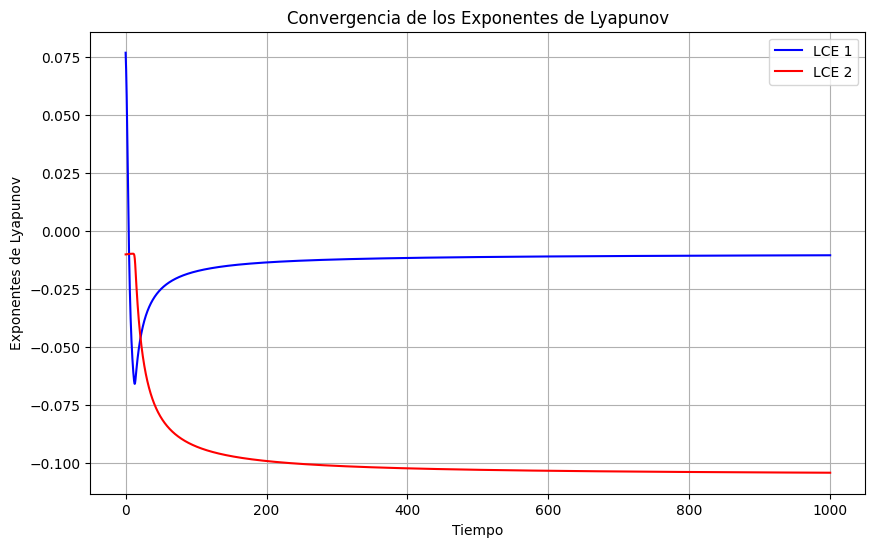

In [107]:
# Convertir lce_convergence en un array de numpy para graficarlo
LCE_convergence = np.array(LCE_convergence)

### GRAFICAR LA CONVERGENCIA DE LOS LCEs ###
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(LCE_convergence)) * reeval * (t_eval[1] - t_eval[0]), LCE_convergence[:, 0], label='LCE 1', color='b')
plt.plot(np.arange(len(LCE_convergence)) * reeval * (t_eval[1] - t_eval[0]), LCE_convergence[:, 1], label='LCE 2', color='r')
plt.xlabel('Tiempo')
plt.ylabel('Exponentes de Lyapunov')
plt.title('Convergencia de los Exponentes de Lyapunov')
plt.legend()
plt.grid()
plt.show()

Los LCEs nos dan información sobre la sensibilidad a las condiciones iniciales y sobre el comportamiento del propio sistema. En nuestro caso, 
- Los LCE suman negativo, lo que implica que el sistema es disipativo.
- Como todos son negativos, no hay evidencia de que sea un sistema caótico.
- Parece que hay atracción hacia un equilibrio (un punto fijo o un foco). 

# Modelo clásico $(K_v \to\infty)$ con ruido
Aplicamos el método de Euler-Maruyama para resolver la ecuación de Languevin. Tras la discretización de $\Delta t = T/N$, obtenemos
$$
x_i^{(n+1)} = x_i^{(n)}+r_ix_i^{(n)}\left( 1-\sum_{j=1}^Na_{ij}x_j^{(n)} \right)\Delta t + \sigma_i x_i^{(n)}\sqrt{\Delta t}\zeta_i^{(n)}.
$$

In [3]:
def euler_maruyama_4esp(model, x0, t_span, dt, r, a, sigma):
    """
    Euler maruyama method
    :param system:  función definida antes
    :param x0: condición inicial (array de len N)
    :param t0: tiempo inicial (float)
    :param t_max: tiempo final (float)
    :param dt: step del tiempo (float)
    :param r: array con r_i
    :param a: matriz con a_ij
    :param sigma: array con sigma_i
    :return: (t_vals, x_vals), con x_vals un array (num_steps+1, N)
    """
    
    np.random.seed(2) # opcional
    N=len(x0) # en nuestro caso será 4
    t0 = t_span[0]
    t_max = t_span[-1]
    num_steps = int((t_max-t0)/dt)
    
    # guardamos los valores 
    t_vals = np.linspace(t0, t_max, num_steps+1)
    x_vals = np.zeros((num_steps+1,N))
    
    x_vals[0, :] = x0
    x = x0.copy()
    
    for n in range(num_steps): # para cada paso temporal
        t = t_vals[n]
        
        # parte determinista
        F = model(t,x,r,a) # también array de 4

        # vector del ruido
        
        for i in range(N): # para cada especie
            # introducimos la variable aletoria
            zetta = np.random.normal(0, 1)
            
            # hallamos el siguiente valor
            x[i] = x[i]+ F[i]*dt + sigma[i]*x[i]*np.sqrt(dt)*zetta
            
            # si baja del umbral, suponemos que se extingue
            if x[i] <= 1e-10:
                x[i] = 0
                
            x_vals[n+1,i] = x[i]    
    return t_vals, x_vals
    


In [4]:
# tomamos los parámetros de antes
N=4
r = np.array(
    [1, 0.72, 1.53, 1.27]
)

a = np.array([
    [1, 1.09, 1.52, 0],
    [0, 1, 0.44, 1.36],
    [2.33, 0, 1, 0.47],
    [1.21, 0.51, 0.35, 1]
])

x0 = np.array([0.5, 0.5, 0.5, 0.5])
t_span = (0, 1000)

# escogemos un paso de tiempo pequeño (IMPORTANTE)
dt = 1e-3

# definimos una intesidad para el ruido
sigma = np.array([0.1, 0.1, 0.1, 0.1])
# sigma = sigma*0

# aplicamos EM
t_vals_EM_4esp, x_vals_EM_4esp = euler_maruyama_4esp(system, x0, t_span, dt, r, a, sigma)
print('tiempo = ', t_vals_EM_4esp)
print('valores de x = ',x_vals_EM_4esp)

tiempo =  [0.00000e+00 1.00000e-03 2.00000e-03 ... 9.99998e+02 9.99999e+02
 1.00000e+03]
valores de x =  [[0.5        0.5        0.5        0.5       ]
 [0.49893855 0.49976703 0.49593388 0.50225377]
 [0.49571099 0.49829243 0.49604379 0.49993503]
 ...
 [0.32723833 0.55072586 0.         0.38607241]
 [0.32727785 0.54983203 0.         0.38847049]
 [0.32595826 0.54688895 0.         0.38757113]]


In [5]:
print('min en x_2', np.min(x_vals_EM_4esp[:,1]))

min en x_2 1.5334101574201558e-07


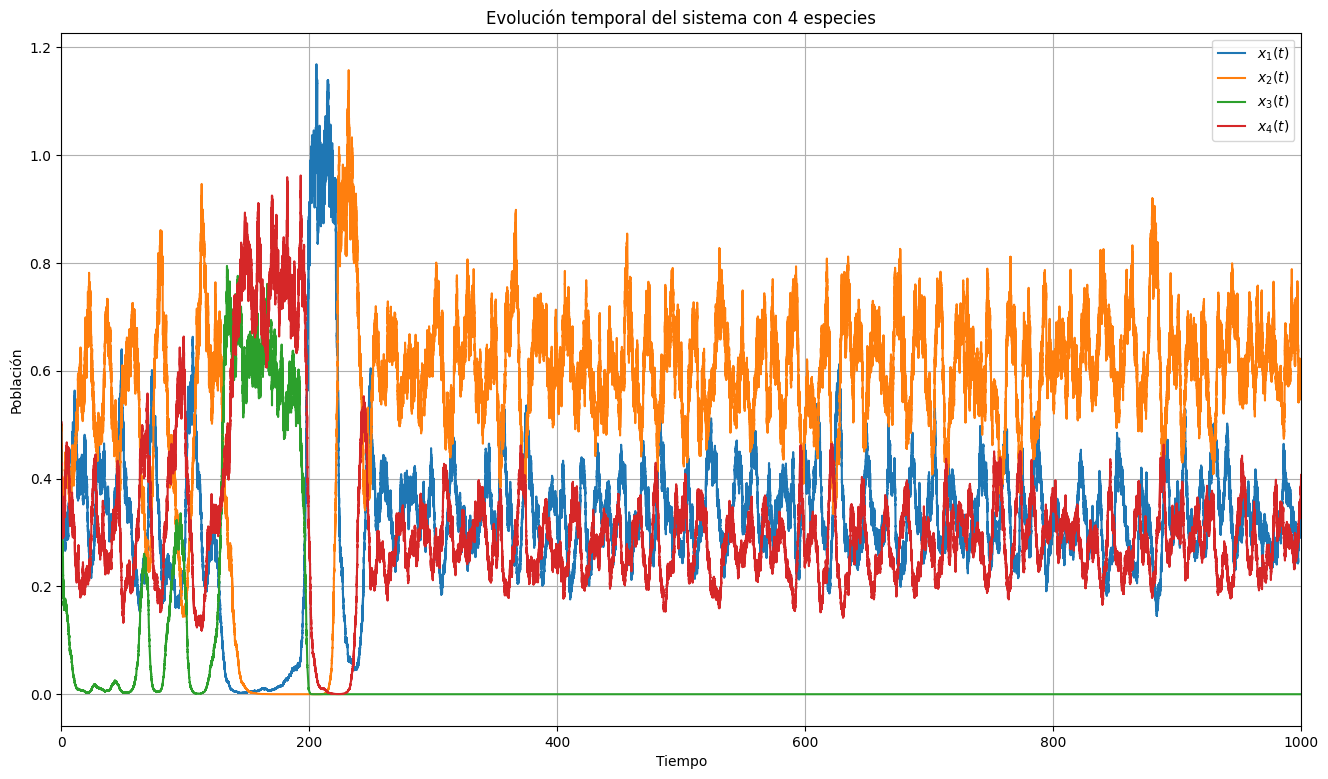

In [6]:
# creamos la gráfica
fig_em, ax_em = plt.subplots(1, 1, figsize=(16,9))

ax_em.plot(t_vals_EM_4esp, x_vals_EM_4esp[:,0], label=f'$x_1(t)$')
ax_em.plot(t_vals_EM_4esp, x_vals_EM_4esp[:,1], label=f'$x_2(t)$')
ax_em.plot(t_vals_EM_4esp, x_vals_EM_4esp[:,2], label=f'$x_3(t)$')
ax_em.plot(t_vals_EM_4esp, x_vals_EM_4esp[:,3], label=f'$x_4(t)$')

# ajustamos las etiquetas y el título
ax_em.set_xlabel('Tiempo')
ax_em.set_ylabel('Población')
ax_em.set_xlim([t_span[0], t_span[-1]])
ax_em.set_title('Evolución temporal del sistema con 4 especies')
ax_em.legend()
ax_em.grid(True)
plt.plot()

# mostramos la gráfica
plt.show()

También podemos hallar su espacio de fases como hicimos cuando estábamos en el caso determinista:

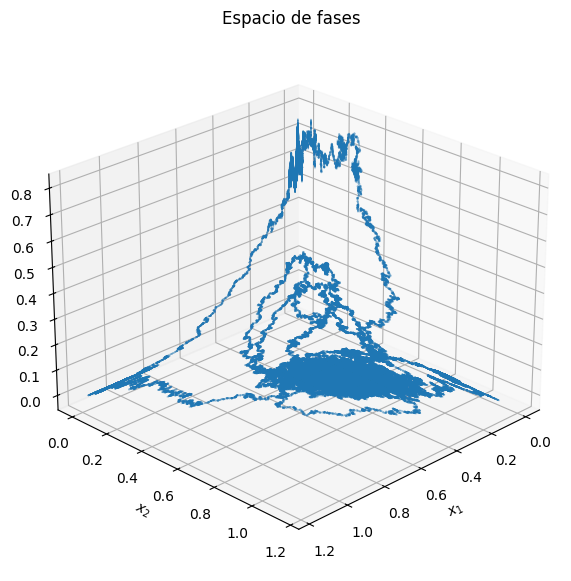

In [12]:
 # %matplotlib notebook


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# dibujamos el espacio de fases
ax.scatter(x_vals_EM_4esp[:,0],x_vals_EM_4esp[:,1],x_vals_EM_4esp[:,2] , label='Espacio de fases', s=0.01)
ax.set_xlabel(f'$x_1$')
ax.set_ylabel(f'$x_2$')
ax.set_zlabel(f'$x_3$')
ax.set_title('Espacio de fases')


ax.view_init(elev=25, azim=45)  # cambia elevación y azimut para rotar la gráfica
plt.show()

Y ahora sus exponentes de Lyapunov (?)

 # Modelo con regulación de densidad añadiendo ruido
Ahora, después de aplicar el método de Euler-Maruyama, tenemos las discretizaciones de ambas ecuaciones, que son:
$$
\begin{align}
x_1^{(n+1)} = x_1 ^{(n)}+r_1 x_1^{(n)}\left( 1-\frac{x_1^{(n)}}{K_v}-\lambda_{12}\frac{x_2^{(n)}}{K_v} \right)\Delta t+ \sigma_1 x_1^{(n)}\sqrt{\Delta t} \zeta_1^{(n)}, \\
x_2^{(n+1)} = x_2^{(n)} -|r_2|x_2^{(n)}\left( 1-\lambda_{21}\frac{x_1^{(n)}}{K_v} \right) \Delta t +\sigma_2 x_2^{(n)}\sqrt{\Delta t} \zeta_2^{(n)}.
\end{align} 
$$

In [107]:
def euler_maruyama_reg(model, x0, t_span, dt, r, a, Kv, sigma):
    """
    Euler maruyama method
    :param system:  función definida antes
    :param x0: condición inicial (array de len N)
    :param t0: tiempo inicial (float)
    :param t_max: tiempo final (float)
    :param dt: step del tiempo (float)
    :param r: array con r_i
    :param a: matriz con a_ij
    :param sigma: array con sigma_i
    :return: (t_vals, x_vals), con x_vals un array (num_steps+1, N)
    """
    
# V0 = .1  
# P0 = .01  
# rv = 1
# rp = 0.1 
# lambda_pv = 0.044 
# lambda_vp = 0.044 
# Kv = 1
    # definimos algunos parámetros
    np.random.seed(2) # para reproducibilidad
    N=len(x0) # en nuestro caso será 4
    t0 = t_span[0]
    t_max = t_span[-1]
    num_steps = int((t_max-t0)/dt)
    lambda12 = a[1,2]
    lambda21 = a[2,1]
    
    # guardamos los valores 
    t_vals = np.linspace(t0, t_max, num_steps+1)
    x_vals = np.zeros((num_steps+1,N))
    
    x_vals[0, :] = x0
    x = x0.copy()
    
    for n in range(num_steps): # para cada paso temporal
        t = t_vals[n]
        
        # parte determinista
        F = model(t,x,r,a) # también array de 4

        # vector del ruido
        
        for i in range(N): # para cada especie
            # introducimos la variable aletoria
            zetta = np.random.normal(0, 1)
            
            # hallamos el siguiente valor
            x[i] = x[i]+ F[i]*dt + sigma[i]*x[i]*np.sqrt(dt)*zetta
            
            # si baja del umbral, suponemos que se extingue
            if x[i] <= 1e-10:
                x[i] = 0
                
            x_vals[n+1,i] = x[i]    
    return t_vals, x_vals